In [32]:
import random
import argparse
import numpy as np
import pandas as po
from tqdm import tqdm
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error

In [2]:
# set random seeds for reproducibility
tf.random.set_seed(42)
np.random.seed(42)
random.seed(42)

In [3]:
df = po.read_csv('final_data/univariate.csv')
df

,consumption
0,126661.288667
1,125975.630600
2,131628.821400
3,133741.109667
4,149806.386667
...,...
99643,103932.504002
99644,102064.379714
99645,100378.796042
99646,98593.460339


In [4]:
scaler = MinMaxScaler()
df = po.DataFrame(scaler.fit_transform(df), columns=df.columns)

In [5]:
train_df = df[:int(0.6*len(df))]
val_df = df[int(0.6*len(df)): int(0.8*len(df))]
test_df = df[int(0.8*len(df)):]

In [6]:
len(train_df), len(val_df), len(test_df)

(59788, 19930, 19930)

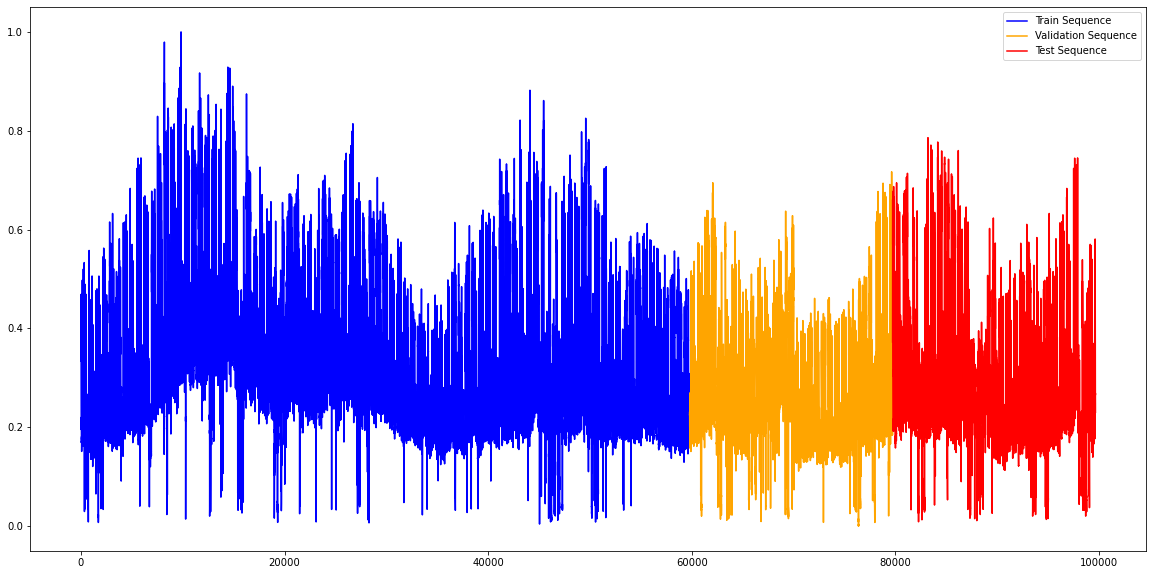

In [7]:
plt.figure(figsize=(20, 10))
plt.plot(train_df['consumption'], color='blue')
plt.plot(val_df['consumption'], color='orange')
plt.plot(test_df['consumption'], color='red')
plt.legend(['Train Sequence', 'Validation Sequence', 'Test Sequence'])

In [8]:
train_df = train_df.reset_index(drop=True)
val_df = val_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)

In [9]:
lookback=4*24*14
horizon=4*24*1

In [10]:
def make_windows(data, target_col='consumption', lookback=4*24*14, horizon=4*24*1):
    
    X = np.zeros((len(data)-lookback - horizon + 1, lookback, len(data.columns)))
    y = np.zeros((len(data)-lookback - horizon + 1, horizon, 1))

    for i in tqdm(range(lookback, len(data) - horizon + 1)):  
        X[i-lookback, :, :] = data.iloc[i - lookback: i].values
        y[i-lookback, :, :] = data.iloc[i: i + horizon][target_col].values.reshape(-1, 1)

    return X, y

In [11]:
X_train, y_train = make_windows(train_df)

100%|██████████| 58349/58349 [00:08<00:00, 6688.93it/s]


In [12]:
X_val, y_val = make_windows(val_df)

100%|██████████| 18491/18491 [00:02<00:00, 6547.06it/s]


In [13]:
X_test, y_test = make_windows(test_df)

100%|██████████| 18491/18491 [00:02<00:00, 6813.87it/s]


In [14]:
sgd = tf.keras.optimizers.SGD(lr=1e-4, decay=1e-8, momentum=0.9, nesterov=True)
earlystop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0.00001, patience=10)
loss_funk = tf.keras.losses.MeanSquaredError(reduction='sum_over_batch_size')

In [15]:
hidden_dim = 100
theta_1 = 100
theta_2 = 100
nb_blocks_per_stack = 20
seasonality = 4*24*7
batch_size = 256
num_epochs = 100

In [16]:
X_train = X_train.squeeze()
y_train = y_train.squeeze()
X_val = X_val.squeeze()
y_val = y_val.squeeze()
X_test = X_test.squeeze()
y_test = y_test.squeeze()

In [17]:
i = tf.keras.layers.Input((lookback))
x = tf.keras.layers.Dense(1000)(i)
x = tf.keras.layers.Dense(500)(x)
x = tf.keras.layers.Dense(horizon)(x)

In [18]:
model = tf.keras.models.Model(inputs=i, outputs=x)
model.compile(optimizer = sgd, loss = loss_funk)

In [19]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 1344)]            0         
_________________________________________________________________
dense (Dense)                (None, 1000)              1345000   
_________________________________________________________________
dense_1 (Dense)              (None, 500)               500500    
_________________________________________________________________
dense_2 (Dense)              (None, 96)                48096     
Total params: 1,893,596
Trainable params: 1,893,596
Non-trainable params: 0
_________________________________________________________________


In [20]:
history = model.fit(X_train, y_train, batch_size = batch_size, epochs = num_epochs, validation_data = (X_val, y_val), callbacks=[earlystop], verbose=1)

Epoch 1/100
228/228 [==============================] - 1s 3ms/step - loss: 0.1582 - val_loss: 0.0453
Epoch 2/100
228/228 [==============================] - 1s 3ms/step - loss: 0.0545 - val_loss: 0.0386
Epoch 3/100
228/228 [==============================] - 1s 3ms/step - loss: 0.0491 - val_loss: 0.0365
Epoch 4/100
228/228 [==============================] - 1s 3ms/step - loss: 0.0462 - val_loss: 0.0349
Epoch 5/100
228/228 [==============================] - 1s 3ms/step - loss: 0.0439 - val_loss: 0.0336
Epoch 6/100
228/228 [==============================] - 1s 3ms/step - loss: 0.0419 - val_loss: 0.0325
Epoch 7/100
228/228 [==============================] - 1s 3ms/step - loss: 0.0403 - val_loss: 0.0315
Epoch 8/100
228/228 [==============================] - 1s 3ms/step - loss: 0.0388 - val_loss: 0.0307
Epoch 9/100
228/228 [==============================] - 1s 3ms/step - loss: 0.0376 - val_loss: 0.0300
Epoch 10/100
228/228 [==============================] - 1s 3ms/step - loss: 0.0365 - val_lo

In [21]:
model.save('saved_models/mlp_univariate.hdf5')

In [22]:
#model = tf.keras.models.load_model('saved_models/nbeats_univ.hdf5')

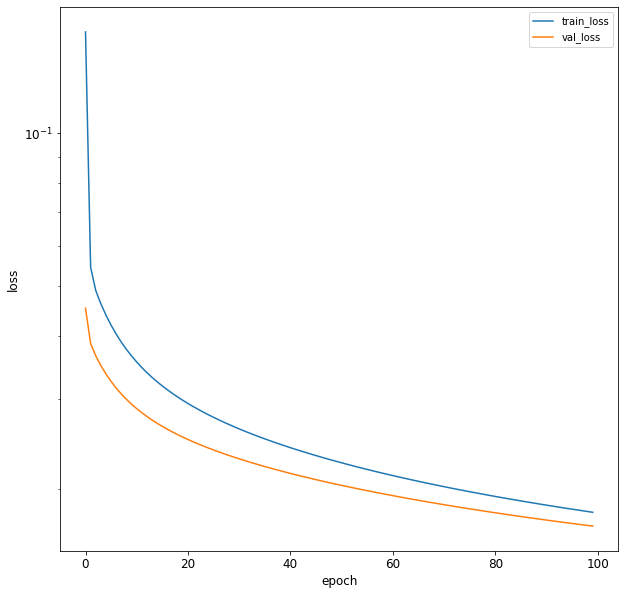

In [23]:
plot_df = po.DataFrame.from_dict({'train_loss':history.history['loss'], 'val_loss':history.history['val_loss']})
plot_df.plot(logy=True, figsize=(10,10), fontsize=12)
plt.xlabel('epoch', fontsize=12)
plt.ylabel('loss', fontsize=12)
#plt.savefig('forecasts/' + args.save_folder + '/train_val_loss.png')
plt.show()

In [24]:
y_pred = model.predict(X_test)

In [25]:
y_pred = y_pred.squeeze()
y_test = y_test.squeeze()

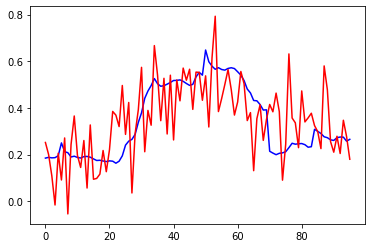

In [26]:
plt.plot(y_test[5251], color = 'blue')
plt.plot(y_pred[5251], color = 'red')
#plt.savefig('forecasts/' + args.save_folder + '/test_1_pred.png')

In [27]:
forecasts = []
actuals = []
forecasts_n = []
actuals_n = []
for i in tqdm(range(y_pred.shape[0]//288)): ## we have forecasts for these many complete day
  forecasts += (scaler.inverse_transform(y_pred[12*24*i].reshape(-1, 1)).reshape(-1)).tolist()
  actuals += (scaler.inverse_transform(y_test[12*24*i].reshape(-1, 1)).reshape(-1)).tolist()
  forecasts_n += y_pred[12*24*i].tolist()
  actuals_n += y_test[12*24*i].tolist()

100%|██████████| 64/64 [00:00<00:00, 6013.47it/s]


In [28]:
df_pred = po.DataFrame()
df_pred['Predictions'] = forecasts
df_pred['Actual Values'] = actuals

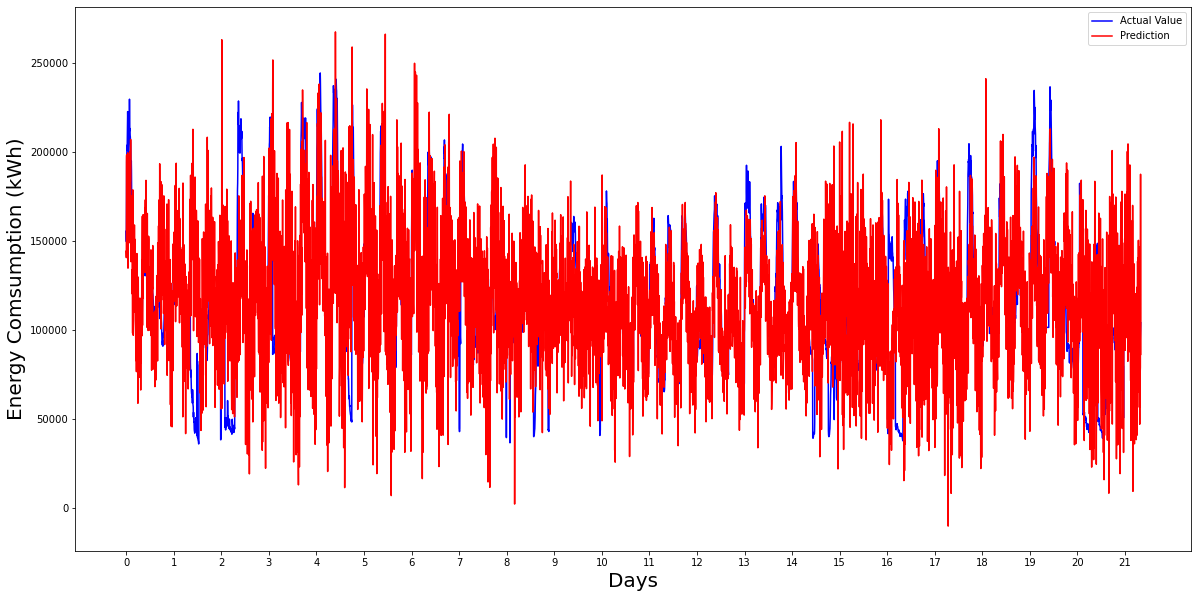

In [29]:
plt.figure(figsize=(20, 10))
plt.xlabel('Days', size = 20)
plt.ylabel('Energy Comsumption (kWh)', size = 20)
plt.xticks(ticks = list(range(0, len(forecasts) + 1, 288)), labels = list(range(0, int(len(forecasts)/288 + 1))), size = 10)
plt.yticks(size = 10)
plt.plot(actuals, color = 'blue')
plt.plot(forecasts, color = 'red')
plt.legend(['Actual Value', 'Prediction'])

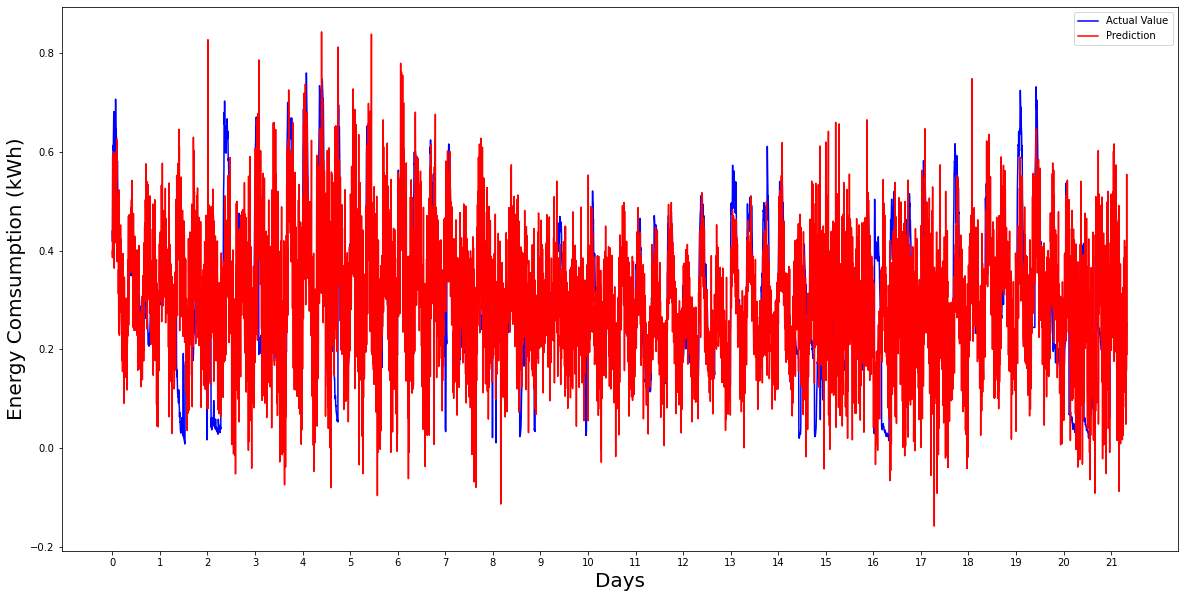

In [30]:
plt.figure(figsize=(20, 10))
plt.xlabel('Days', size = 20)
plt.ylabel('Energy Comsumption (kWh)', size = 20)
plt.xticks(ticks = list(range(0, len(forecasts) + 1, 288)), labels = list(range(0, int(len(forecasts)/288 + 1))), size = 10)
plt.yticks(size = 10)
plt.plot(actuals_n, color = 'blue')
plt.plot(forecasts_n, color = 'red')
plt.legend(['Actual Value', 'Prediction'])

In [31]:
results = po.DataFrame(columns = ['MAE', 'MSE', 'R2'])  
errors = {'MAE': mean_absolute_error(y_true=y_test, y_pred=y_pred),
          'MAPE': mean_absolute_error(y_true=y_test, y_pred=y_pred)*100,
          'MSE': mean_squared_error(y_true=y_test, y_pred=y_pred),
          'RMSE': mean_squared_error(y_true=y_test, y_pred=y_pred, squared=False),
          'R2': r2_score(y_true=y_test, y_pred=y_pred)          
          }
errors = po.Series(errors)
results = results.append(errors, ignore_index=True)
results

,MAE,MSE,R2,MAPE,RMSE
0,0.112819,0.021548,-0.234508,11.281897,0.146791
